In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [20]:

class MNISTDataModule(LightningDataModule):
    def __init__(self, batch_size=50):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.MNIST(root='./data', train=True, download=True)

    def setup(self, stage=None):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        full_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
        self.subset1, self.subset2 = random_split(full_dataset, [600, len(full_dataset) - 600])

    def train_dataloader(self, subset=1):
        subset = self.subset1 if subset == 1 else self.subset2
        return DataLoader(subset, batch_size=self.batch_size, shuffle=True)

In [21]:
class CNN(LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 10)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        return loss

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01)


In [12]:
def average_model_parameters(models, average_weights):
    averaged_params = {}
    for key in models[0].state_dict().keys():
        averaged_params[key] = sum(
            weight * models[i].state_dict()[key]
            for i, weight in enumerate(average_weights)
        )
    return averaged_params

In [13]:
data_module = MNISTDataModule(batch_size=50)
data_module.prepare_data()
data_module.setup()

In [ ]:
data_module = MNISTDataModule(batch_size=50)
data_module.prepare_data()
data_module.setup()

model1 = CNN()
model2 = CNN()


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_worker

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 69.45it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 66.86it/s, v_num=2]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



Epoch 0: 100%|██████████| 1188/1188 [00:10<00:00, 118.39it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1188/1188 [00:10<00:00, 118.32it/s, v_num=3]
Accuracy Model 1 (Before Update): 0.14
Accuracy Model 2 (Before Update): 0.93
Accuracy Model 1 (After Update): 0.76
Accuracy Model 2 (After Update): 0.74


In [14]:
# Entraîner chaque modèle localement
trainer1 = Trainer(max_epochs=1)
trainer1.fit(model1, train_dataloaders=data_module.train_dataloader(subset=1))

trainer2 = Trainer(max_epochs=1)
trainer2.fit(model2, train_dataloaders=data_module.train_dataloader(subset=2))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode
------------------------------------------------------
0 | conv1     | Conv2d           | 320    | eval
1 | conv2     | Conv2d           | 18.5 K | eval
2 | fc1       | Linear           | 401 K  | eval
3 | fc2       | Linear           | 1.3 K  | eval
4 | criterion | CrossEntropyLoss | 0      | eval
------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
0         Modules in train mode
5         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 80.03it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 75.72it/s, v_num=4]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode
------------------------------------------------------
0 | conv1     | Conv2d           | 320    | eval
1 | conv2     | Conv2d           | 18.5 K | eval
2 | fc1       | Linear           | 401 K  | eval
3 | fc2       | Linear           | 1.3 K  | eval
4 | criterion | CrossEntropyLoss | 0      | eval
------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
0         Modules in train mode
5         Modules in eval mode



Epoch 0: 100%|██████████| 1188/1188 [00:10<00:00, 117.50it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1188/1188 [00:10<00:00, 117.36it/s, v_num=5]


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return correct / total

In [15]:
accuracy1_before = evaluate_model(model1, data_module.train_dataloader(subset=1))
accuracy2_before = evaluate_model(model2, data_module.train_dataloader(subset=2))

print(f"Accuracy Model 1 (Before Update): {accuracy1_before:.2f}")
print(f"Accuracy Model 2 (Before Update): {accuracy2_before:.2f}")

averaged_params = average_model_parameters([model1, model2], [0.5, 0.5])

model1.load_state_dict(averaged_params)
model2.load_state_dict(averaged_params)

accuracy1_after = evaluate_model(model1, data_module.train_dataloader(subset=1))
accuracy2_after = evaluate_model(model2, data_module.train_dataloader(subset=2))

print(50*"-")
print(f"Accuracy Model 1 (After Update): {accuracy1_after:.2f}")
print(f"Accuracy Model 2 (After Update): {accuracy2_after:.2f}")

Accuracy Model 1 (Before Update): 0.89
Accuracy Model 2 (Before Update): 0.95
--------------------------------------------------
Accuracy Model 1 (After Update): 0.93
Accuracy Model 2 (After Update): 0.94


# Initialisation avec les parametres communs

In [22]:
def initialize_common_parameters(model1, model2):
    model2.load_state_dict(model1.state_dict())

In [23]:
model1 = CNN()
model2 = CNN()

initialize_common_parameters(model1, model2)

trainer1 = Trainer(max_epochs=1)
trainer2 = Trainer(max_epochs=1)

trainer1.fit(model1, train_dataloaders=data_module.train_dataloader(subset=1))

trainer2.fit(model2, train_dataloaders=data_module.train_dataloader(subset=2))


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 63.46it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 60.33it/s, v_num=6]



  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1188/1188 [00:09<00:00, 122.69it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1188/1188 [00:09<00:00, 122.62it/s, v_num=7]
Accuracy Model 1 (Before Averaging, Common Init): 0.18
Accuracy Model 2 (Before Averaging, Common Init): 0.94
Accuracy Model 1 (After Averaging, Common Init): 0.92
Accuracy Model 2 (After Averaging, Common Init): 0.92


In [25]:
accuracy1_before = evaluate_model(model1, data_module.train_dataloader(subset=1))
accuracy2_before = evaluate_model(model2, data_module.train_dataloader(subset=2))

print(f"Accuracy Model 1 (Before Averaging, Common Init): {accuracy1_before:.2f}")
print(f"Accuracy Model 2 (Before Averaging, Common Init): {accuracy2_before:.2f}")

averaged_params = average_model_parameters([model1, model2], [0.5, 0.5])

model1.load_state_dict(averaged_params)
model2.load_state_dict(averaged_params)

accuracy1_after = evaluate_model(model1, data_module.train_dataloader(subset=1))
accuracy2_after = evaluate_model(model2, data_module.train_dataloader(subset=2))

print(f"Accuracy Model 1 (After Averaging, Common Init): {accuracy1_after:.2f}")
print(f"Accuracy Model 2 (After Averaging, Common Init): {accuracy2_after:.2f}")

Accuracy Model 1 (Before Averaging, Common Init): 0.92
Accuracy Model 2 (Before Averaging, Common Init): 0.92
Accuracy Model 1 (After Averaging, Common Init): 0.92
Accuracy Model 2 (After Averaging, Common Init): 0.92


# Differentes Batch Size

In [26]:
def train_with_batch_size(batch_size):
    print(f"Training with batch size: {batch_size}")

    data_module = MNISTDataModule(batch_size=batch_size)
    data_module.prepare_data()
    data_module.setup()

    model1 = CNN()
    model2 = CNN()

    trainer1 = Trainer(max_epochs=1)
    trainer2 = Trainer(max_epochs=1)

    trainer1.fit(model1, train_dataloaders=data_module.train_dataloader(subset=1))
    trainer2.fit(model2, train_dataloaders=data_module.train_dataloader(subset=2))

    accuracy1_before = evaluate_model(model1, data_module.train_dataloader(subset=1))
    accuracy2_before = evaluate_model(model2, data_module.train_dataloader(subset=2))

    print(f"Accuracy Model 1 (Before Averaging): {accuracy1_before:.2f}")
    print(f"Accuracy Model 2 (Before Averaging): {accuracy2_before:.2f}")

    averaged_params = average_model_parameters([model1, model2], [0.5, 0.5])

    model1.load_state_dict(averaged_params)
    model2.load_state_dict(averaged_params)

    accuracy1_after = evaluate_model(model1, data_module.train_dataloader(subset=1))
    accuracy2_after = evaluate_model(model2, data_module.train_dataloader(subset=2))

    print(f"Accuracy Model 1 (After Averaging): {accuracy1_after:.2f}")
    print(f"Accuracy Model 2 (After Averaging): {accuracy2_after:.2f}")

    return {
        "batch_size": batch_size,
        "accuracy1_before": accuracy1_before,
        "accuracy2_before": accuracy2_before,
        "accuracy1_after": accuracy1_after,
        "accuracy2_after": accuracy2_after,
    }


In [28]:
batch_sizes = [50, 25, 10, 5]

results = []

for batch_size in batch_sizes:
    result = train_with_batch_size(batch_size)
    results.append(result)

for res in results:
    print(f"Batch Size: {res['batch_size']}")
    print(f"Accuracy Before Averaging - Model 1: {res['accuracy1_before']:.2f}, Model 2: {res['accuracy2_before']:.2f}")
    print(f"Accuracy After Averaging - Model 1: {res['accuracy1_after']:.2f}, Model 2: {res['accuracy2_after']:.2f}")
    print("-----")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have 

Training with batch size: 50
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 69.73it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 65.60it/s, v_num=8]


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



Epoch 0: 100%|██████████| 1188/1188 [00:10<00:00, 113.34it/s, v_num=9]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1188/1188 [00:10<00:00, 113.26it/s, v_num=9]
Accuracy Model 1 (Before Averaging): 0.11
Accuracy Model 2 (Before Averaging): 0.94


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (24) is smaller than the 

Accuracy Model 1 (After Averaging): 0.84
Accuracy Model 2 (After Averaging): 0.82
Training with batch size: 25
Epoch 0: 100%|██████████| 24/24 [00:00<00:00, 32.84it/s, v_num=10]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 24/24 [00:00<00:00, 31.26it/s, v_num=10]


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



Epoch 0: 100%|██████████| 2376/2376 [00:15<00:00, 149.46it/s, v_num=11]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2376/2376 [00:15<00:00, 149.37it/s, v_num=11]
Accuracy Model 1 (Before Averaging): 0.25
Accuracy Model 2 (Before Averaging): 0.96


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Accuracy Model 1 (After Averaging): 0.85
Accuracy Model 2 (After Averaging): 0.86
Training with batch size: 10
Epoch 0: 100%|██████████| 60/60 [00:00<00:00, 91.82it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 60/60 [00:00<00:00, 90.66it/s, v_num=12]


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



Epoch 0: 100%|██████████| 5940/5940 [00:31<00:00, 188.03it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 5940/5940 [00:31<00:00, 187.96it/s, v_num=13]
Accuracy Model 1 (Before Averaging): 0.17
Accuracy Model 2 (Before Averaging): 0.98


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Accuracy Model 1 (After Averaging): 0.78
Accuracy Model 2 (After Averaging): 0.77
Training with batch size: 5
Epoch 0: 100%|██████████| 120/120 [00:01<00:00, 66.11it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 120/120 [00:01<00:00, 65.88it/s, v_num=14]



  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 320    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 401 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 11880/11880 [01:01<00:00, 193.06it/s, v_num=15]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 11880/11880 [01:01<00:00, 193.03it/s, v_num=15]
Accuracy Model 1 (Before Averaging): 0.40
Accuracy Model 2 (Before Averaging): 0.97
Accuracy Model 1 (After Averaging): 0.95
Accuracy Model 2 (After Averaging): 0.96
Batch Size: 50
Accuracy Before Averaging - Model 1: 0.11, Model 2: 0.94
Accuracy After Averaging - Model 1: 0.84, Model 2: 0.82
-----
Batch Size: 25
Accuracy Before Averaging - Model 1: 0.25, Model 2: 0.96
Accuracy After Averaging - Model 1: 0.85, Model 2: 0.86
-----
Batch Size: 10
Accuracy Before Averaging - Model 1: 0.17, Model 2: 0.98
Accuracy After Averaging - Model 1: 0.78, Model 2: 0.77
-----
Batch Size: 5
Accuracy Before Averaging - Model 1: 0.40, Model 2: 0.97
Accuracy After Averaging - Model 1: 0.95, Model 2: 0.96
-----


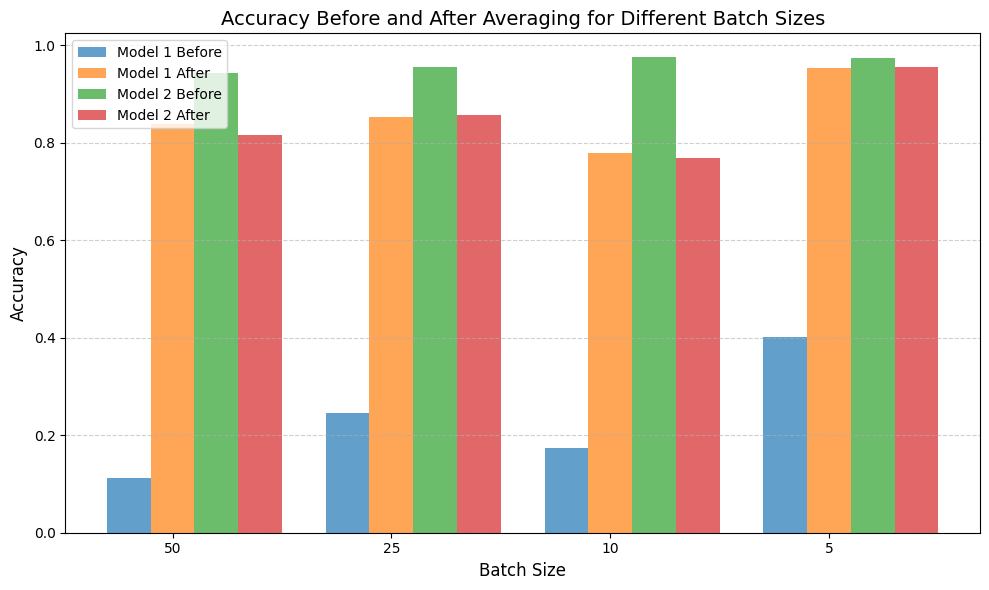

In [29]:
batch_sizes = [res["batch_size"] for res in results]
accuracy1_before = [res["accuracy1_before"] for res in results]
accuracy2_before = [res["accuracy2_before"] for res in results]
accuracy1_after = [res["accuracy1_after"] for res in results]
accuracy2_after = [res["accuracy2_after"] for res in results]

bar_width = 0.2
x = range(len(batch_sizes))

plt.figure(figsize=(10, 6))

plt.bar([pos - bar_width for pos in x], accuracy1_before, bar_width, label="Model 1 Before", alpha=0.7)
plt.bar(x, accuracy1_after, bar_width, label="Model 1 After", alpha=0.7)
plt.bar([pos + bar_width for pos in x], accuracy2_before, bar_width, label="Model 2 Before", alpha=0.7)
plt.bar([pos + 2 * bar_width for pos in x], accuracy2_after, bar_width, label="Model 2 After", alpha=0.7)

plt.xlabel("Batch Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Before and After Averaging for Different Batch Sizes", fontsize=14)
plt.xticks(x, batch_sizes, fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

On peut remarquer que les grandes tailles de batch donnent de meilleures performances locales avant le moyennage grâce à des gradients plus stables. Cependant, après l'application du Federated Averaging les performances s'améliorent pour tous les modèles meme ceux entraînés avec des petits batchs.

### CIFAR-10

In [30]:
class CIFAR10DataModule(LightningDataModule):
    def __init__(self, batch_size=50):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.CIFAR10(root='./data', train=True, download=True)

    def setup(self, stage=None):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform)
        self.subset1, self.subset2 = random_split(full_dataset, [600, len(full_dataset) - 600])

    def train_dataloader(self, subset=1):
        subset = self.subset1 if subset == 1 else self.subset2
        return DataLoader(subset, batch_size=self.batch_size, shuffle=True)


In [31]:
class CIFARCNN(LightningModule):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  
        self.fc2 = nn.Linear(128, 10)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        return loss

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01)


In [32]:
data_module = CIFAR10DataModule(batch_size=50)
data_module.prepare_data()
data_module.setup()

model1 = CIFARCNN()
model2 = CIFARCNN()

trainer1 = Trainer(max_epochs=1)
trainer2 = Trainer(max_epochs=1)

trainer1.fit(model1, train_dataloaders=data_module.train_dataloader(subset=1))
trainer2.fit(model2, train_dataloaders=data_module.train_dataloader(subset=2))

100%|██████████| 170M/170M [02:48<00:00, 1.01MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 896    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 524 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
545 K     Trainable params
0         Non-trainable params
545 K     Total params
2.180     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have 

Epoch 0: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:01<00:00,  9.54it/s, v_num=16]


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 896    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | fc1       | Linear           | 524 K  | train
3 | fc2       | Linear           | 1.3 K  | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
545 K     Trainable params
0         Non-trainable params
545 K     Total params
2.180     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



Epoch 0: 100%|██████████| 988/988 [00:09<00:00, 100.56it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 988/988 [00:09<00:00, 100.50it/s, v_num=17]


In [33]:
accuracy1_before = evaluate_model(model1, data_module.train_dataloader(subset=1))
accuracy2_before = evaluate_model(model2, data_module.train_dataloader(subset=2))

print(f"Accuracy Model 1 (Before Averaging): {accuracy1_before:.2f}")
print(f"Accuracy Model 2 (Before Averaging): {accuracy2_before:.2f}")

averaged_params = average_model_parameters([model1, model2], [0.5, 0.5])

model1.load_state_dict(averaged_params)
model2.load_state_dict(averaged_params)

accuracy1_after = evaluate_model(model1, data_module.train_dataloader(subset=1))
accuracy2_after = evaluate_model(model2, data_module.train_dataloader(subset=2))

print(f"Accuracy Model 1 (After Averaging): {accuracy1_after:.2f}")
print(f"Accuracy Model 2 (After Averaging): {accuracy2_after:.2f}")

Accuracy Model 1 (Before Averaging): 0.11
Accuracy Model 2 (Before Averaging): 0.39
Accuracy Model 1 (After Averaging): 0.25
Accuracy Model 2 (After Averaging): 0.25
